***IMPORT LIBRARIES***

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
import datetime
%matplotlib inline

from scipy.spatial.distance import euclidean
from sklearn.svm import OneClassSVM
from sklearn.cluster import MiniBatchKMeans
from luminol import *
from luminol.modules.time_series import TimeSeries
from luminol.anomaly_detector import AnomalyDetector

---

***Recreating USPS Nearest-Neighbors Martingales from "Testing Exchangeability On-Line" (Vovk)***


**FUNCTION: Strangeness - Nearest Neighbor**

In [2]:
def strangeness_nn(x, y, start_point, end_point):
    n = len(x)
    i = 0
    j = 0
    num_array = []
    denom_array = []

    if start_point == 0:
        start_point = 1
    
    for i in range(start_point, end_point):

        min_dist_num = 100000
        min_dist_denom = 100000

        for j in range(0, i):

            if y.iloc[i] == y.iloc[j]:
                dist_num = euclidean(x.iloc[i, :], x.iloc[j, :])

                if dist_num < min_dist_num:
                    min_dist_num = dist_num

            elif y.iloc[i] <> y.iloc[j]:
                dist_denom = euclidean(x.iloc[i, :], x.iloc[j, :])

                if dist_denom < min_dist_denom:
                    min_dist_denom = dist_denom

        num_array.append(min_dist_num)
        denom_array.append(min_dist_denom)


    strangeness_array = np.divide(num_array, denom_array)
    
    return strangeness_array

**FUNCTION: Calculate p-values of Strangeness Array** 

In [3]:
def p_values(strangeness_array):

    p_val_array = [1]

    for i in range(1, len(strangeness_array)):

        count = 0.

        for j in range(0, i):

            if strangeness_array[i] < strangeness_array[j]:

                count = count + 1.

        #per paper, p-val is #{i: αi ≥ αn} / n  --- strangeness at n is less than or equal to prev samples INCLUDING at n.
        p_val = (count + 1) / (i + 1)  

        p_val_array.append(p_val)
        
    return p_val_array

**FUNCTION: Calculate Martingale Values**

In [4]:
def martingale_values(p_val_array, epsilon):

    martingale_array = [1]

    for i in range(1, len(p_val_array)):

        martingale_at_i = epsilon * (p_val_array[i] ** (epsilon - 1))

        martingale_val = martingale_at_i * martingale_array[i - 1]

        martingale_array.append(martingale_val)
    
    return martingale_array

**LOAD & CLEAN DATA**

In [5]:
train = pd.read_csv('usps_train.csv')
test = pd.read_csv('usps_test.csv')

data = pd.concat((train, test), axis=0)

y = data.iloc[:, -1]
x = data.iloc[:, :-1]

**RUN MARTINGALE FUNCTIONS: NEAREST NEIGHBOR**

In [6]:
start_point = 100
end_point = 500

strangeness_array_nn = strangeness_nn(x, y, start_point, end_point)

p_val_array_nn = p_values(strangeness_array_nn)

In [7]:
epsilon_range = np.arange(0, 1.01, 0.1)

epsilon_range[0] = 0.01

log_final_mart_array = []

for i in range(0, len(epsilon_range)):

    martingale_array_nn = martingale_values(p_val_array_nn, epsilon_range[i])
    
    log_final_mart_val = np.log10(martingale_array_nn[-1])

    log_final_mart_array.append(log_final_mart_val)

**COMPARE OUR NN POWER MARTINGALES TO VOVK**

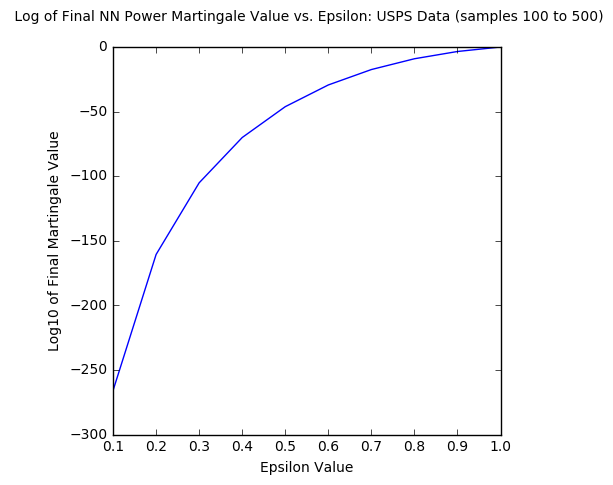

In [8]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(epsilon_range, log_final_mart_array)
ax.set_title(' Log of Final NN Power Martingale Value vs. Epsilon: USPS Data (samples ' + str(start_point) + ' to ' + str(end_point) + ')', fontsize=10)
ax.set_xlabel('Epsilon Value')
ax.set_ylabel('Log10 of Final Martingale Value')
ax.title.set_position([.5, 1.05])
plt.show()

**VOVK - NN Power Martingales as Function of Epsilon: Full USPS Dataset**

<img style="float: left;" src="vovk_fig1.jpg">

---

***USE LUMINOL PACKAGE FOR ANOMALY DETECTION***

**FUNCTION: Detect Anomalies in Data Using Luminol Package**

In [9]:
def anomaly_detector(y):
    y_dict = y.to_dict()
    ts = TimeSeries(y_dict)

    anomaly_dect = AnomalyDetector(ts, algorithm_name='derivative_detector')
    
    scores = anomaly_dect.get_all_scores().values
    
    return scores

**FUNCTION: Plot Anomalies & Underlying Time-Series Data**

In [10]:
def plot_anomalies(time_axis, time_series_data, anom_scores, anom_min, anom_max, y_label, title):

    fig, ax1 = plt.subplots(figsize=(8,5))

    ax2 = ax1.twinx()
    ax1.plot(time_axis, time_series_data, 'g-')
    ax2.plot(time_axis, anom_scores, 'b-')

    ax1.set_title(title)
    ax1.set_xlabel('Year')
    ax1.set_ylabel(y_label, color='g')
    ax2.set_ylabel('Anomaly Score', color='b')

    ax2.set_ylim([anom_min, anom_max])

    plt.show()

**LOAD DATA & PLOT ANOMALIES: S&P 500 Index per Year**

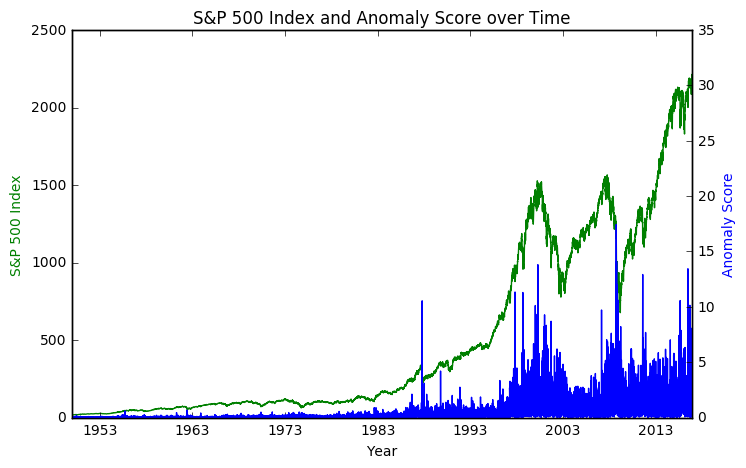

In [11]:
df_raw_SPX = pd.read_csv('SPX_010350_120516.csv')

df_SPX = df_raw_SPX.iloc[::-1]
df_SPX.reset_index(drop=True, inplace=True)

date_raw_SPX = df_SPX.iloc[:, 0]
date_SPX = pd.to_datetime(date_raw_SPX)

x_SPX = df_SPX.iloc[:,1:-1];
y_SPX = df_SPX.iloc[:,-1];

scores_SPX = anomaly_detector(y_SPX)

plot_anomalies(date_SPX, y_SPX, scores_SPX, 0, 35, 'S&P 500 Index', 'S&P 500 Index and Anomaly Score over Time')

**LOAD DATA & PLOT ANOMALIES: Increase of Length of Earth-Day per Year (in microseconds)**

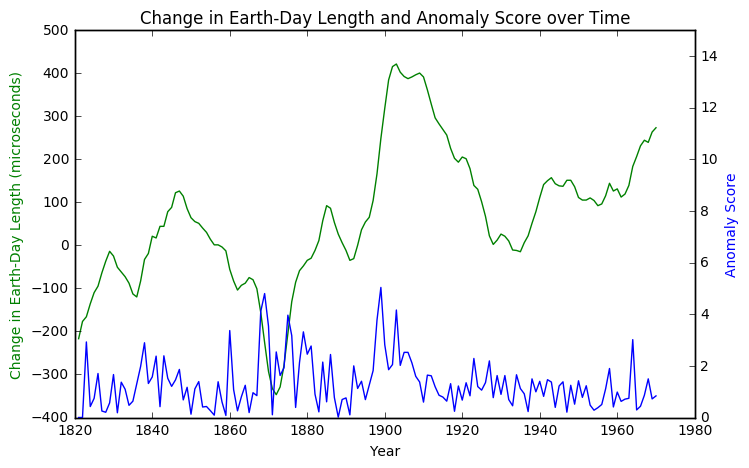

In [12]:
df_EARTH = pd.read_csv('earth_day_change_per_year_1821_1970.csv')

date_EARTH = df_EARTH.iloc[:, 0]

x_EARTH = df_EARTH.iloc[:,1:-1];
y_EARTH = df_EARTH.iloc[:,-1];

scores_EARTH = anomaly_detector(y_EARTH)

plot_anomalies(date_EARTH, y_EARTH, scores_EARTH, 0, 15, 'Change in Earth-Day Length (microseconds)', 'Change in Earth-Day Length and Anomaly Score over Time')

**LOAD DATA & PLOT ANOMALIES: Annual Rainfall in Fortaleza, Brazil (in mm)**

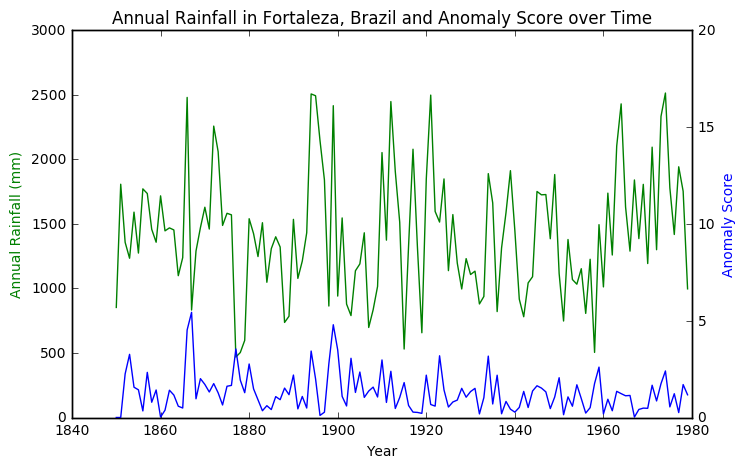

In [13]:
df_FORTALEZA = pd.read_csv('annual_rainfall_fortaleza_1850_1979.csv')

date_FORTALEZA = df_FORTALEZA.iloc[:, 0]

x_FORTALEZA = df_FORTALEZA.iloc[:,1:-1];
y_FORTALEZA = df_FORTALEZA.iloc[:,-1];

scores_FORTALEZA = anomaly_detector(y_FORTALEZA)

plot_anomalies(date_FORTALEZA, y_FORTALEZA, scores_FORTALEZA, 0, 20, 'Annual Rainfall (mm)', 'Annual Rainfall in Fortaleza, Brazil and Anomaly Score over Time')

---

**GRAVEYARD**

In [14]:


clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(xtrain)
y_pred_train = clf.predict(xtrain)
#y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

NameError: name 'xtrain' is not defined

In [ ]:
# Randomized probability of obtaining set vals given strangeness measure
def pfn(vals, strangeness_fn):
    a_n = strangeness_fn(vals[-1])
    i_greater = 0
    i_equal = 0
    n = len(vals)
    for k in range(0, n-1):
        a_k = strangeness_fn(val[k])
        if a_k > a_n: i_greater += 1
        elif a_k == a_n: i_equal += 1
    theta = np.random.rand()
    pval = (i_greater + theta*i_equal)/n
    retdfurn pval

In [ ]:
# Gaussian kernel for adiabatic incremental SVM
class IncrementalSVM:
    
    def __init__(self, ):
        

In [ ]:
epsilon = 0.92

class RandomizedPowerMartingale:
    
    def __init__(self, pfn, sfn, epsilon):
        self._pfn = pfn
        self._sfn = sfn
        self._epsilon = epsilon
        self._pval_i = 1
        self._m_ip = 1
        self._m_i = 1
        self._i = 0
        
    def stream(self, stream):
        val = stream.next()
        while val is not None:
            self._pval_i = self._pfn(item)
            self._m_ip = self._m_i
            self._m_i *= self._epsilon*self._pval_i**(self._epsilon-1)          
            i += 1
            val = stream.next()
            
    def test1(self, lamb):
        return self._m_i >= lamb
   
    def test2(self, t):
        return abs(self._m_i - self._m_ip) >= t

In [ ]:
# df_cols = list(df_raw.columns.values)

# print df_cols

# np_zeros = np.zeros((df_raw.shape[0], df_raw.shape[1]))

# print np_zeros.shape

# df_blank = pd.DataFrame(np_zeros, columns=df_cols)

# print df_blank.head(5)
# print df_blank.shape

In [ ]:
# n = len(df_raw)

# for i in range(0, n):
    
#     df_blank.iloc[i, :] = df_raw.iloc[(n - i - 1), :]
    
# df = df_blank

# print df.head(5)

In [ ]:
# for a in anoms:
#     end = df.ix[a.start_timestamp,0]
#     start = df.ix[a.end_timestamp,0]

#     print(start + '-' + end + '-' + str(a.anomaly_score))